# Time Series Prediction


In [1]:
# @ Lukman copyright 
# MIT Licence

In [2]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
tf.enable_eager_execution()

#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random

In [3]:
import sys

In [4]:
sys.executable

'/home/cat/anaconda3/envs/cat/bin/python'

In [5]:
# enable eager executinon
tf.enable_eager_execution()

In [6]:
tf.__version__

'1.15.0'

# Data Preprocessing 

In [7]:
# I will Load only the zero meter data set 
# same syntax applied for other data set
meterOneDataLOaded= pd.read_csv('meterOneTrainData.csv')
# all meter types data set could be analysed in same manner

In [8]:
meterOneDataLOaded[1:3]

,Unnamed: 0,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1,1,162,1,2016-01-01 00:00:00,0.0000,2,Education,98829,1968.0,NaN,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
2,2,163,1,2016-01-01 00:00:00,4.5719,2,Education,72102,1970.0,NaN,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6


In [9]:
# delete column unnmaed
del meterOneDataLOaded['Unnamed: 0']

In [10]:
# column values 
meterOneDataLOaded.columns.tolist()

['building_id',
 'meter',
 'timestamp',
 'meter_reading',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [11]:
# store column as list
columns = meterOneDataLOaded.columns.tolist()

In [12]:
# get null values per column in the data set
meterOneDataLOaded.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            2819559
floor_count           3972549
air_temperature         23502
cloud_coverage        1742296
dew_temperature         24341
precip_depth_1_hr      541565
sea_level_pressure     105047
wind_direction         402544
wind_speed              37330
dtype: int64

In [13]:
# chnage to time sta
meterOneDataLOaded['timestamp'] =  pd.to_datetime(meterOneDataLOaded['timestamp'])


In [14]:
# check the unique time stamp present
pd.DatetimeIndex(meterOneDataLOaded['timestamp']).year.unique()

Int64Index([2016], dtype='int64', name='timestamp')

In [15]:
meterOneDataLOaded.dtypes

building_id                    int64
meter                          int64
timestamp             datetime64[ns]
meter_reading                float64
site_id                        int64
primary_use                   object
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
cloud_coverage               float64
dew_temperature              float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
dtype: object

In [16]:
# choose windpseed because it has fewer null values
meterOneDataLOaded.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            2819559
floor_count           3972549
air_temperature         23502
cloud_coverage        1742296
dew_temperature         24341
precip_depth_1_hr      541565
sea_level_pressure     105047
wind_direction         402544
wind_speed              37330
dtype: int64

In [17]:
# set time stamp as index 
meterOneDataLOaded.set_index('timestamp',inplace=True);


In [18]:
meterOneDataLOaded['dew_temperature'][1:2]

timestamp
2016-01-01   -5.6
Name: dew_temperature, dtype: float64

#### Model 


In [19]:
# a subset of the data has been copied to use to test the visualizer function
# use the full data set if space is available and system is fast

train_test = meterOneDataLOaded[['meter_reading', 'square_feet', 'air_temperature','primary_use','site_id','dew_temperature']][1:40000].copy()


In [20]:

# reset the index so that time is no longer the index
# the index is now  numbers 
train_test.reset_index(level=0, inplace=True)


In [21]:
# only 2016 data is represented here as usual
pd.DatetimeIndex(train_test['timestamp']).year.unique()

Int64Index([2016], dtype='int64', name='timestamp')

In [22]:
# extrac year month and day
train_test['year'] = pd.DatetimeIndex(train_test['timestamp']).year
train_test['month'] = pd.DatetimeIndex(train_test['timestamp']).month
train_test['day'] = pd.DatetimeIndex(train_test['timestamp']).day

In [23]:
# check null values
train_test.isnull().sum()

timestamp             0
meter_reading         0
square_feet           0
air_temperature    2536
primary_use           0
site_id               0
dew_temperature    2536
year                  0
month                 0
day                   0
dtype: int64

In [24]:
# check data types
train_test.dtypes

timestamp          datetime64[ns]
meter_reading             float64
square_feet                 int64
air_temperature           float64
primary_use                object
site_id                     int64
dew_temperature           float64
year                        int64
month                       int64
day                         int64
dtype: object

In [25]:
# forward filling missing values since values from previous timestamp should
# ideally be similar to the next one. (temperature today and tomorrow should be quite similar)
train_test['air_temperature'].fillna(method='ffill', inplace=True)
train_test['dew_temperature'].fillna(method='ffill', inplace=True)

In [26]:
# delete year we wont use the year information in the model
del train_test['year']

In [27]:
# encode site id and primary use
train_test = pd.get_dummies(train_test, columns=["primary_use","site_id"])

In [28]:
# there are 8908 meter readings with value of zero. let us remove those
train_test[train_test['meter_reading'] <= 0.]['meter_reading'].count() 

11743

In [29]:
# remove columns with meter readings of zero
train_test = train_test[train_test.meter_reading != 0]

In [30]:
train_test[train_test['meter_reading'] <= 0.]['meter_reading'].count() 

0

In [31]:
train_test.head()

,timestamp,meter_reading,square_feet,air_temperature,dew_temperature,month,day,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,...,primary_use_Utility,site_id_2,site_id_6,site_id_7,site_id_9,site_id_10,site_id_11,site_id_13,site_id_14,site_id_15
1,2016-01-01,4.5719,72102,15.6,-5.6,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2016-01-01,209.8860,553210,15.6,-5.6,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2016-01-01,51.5570,183460,15.6,-5.6,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,2016-01-01,176.6860,179559,15.6,-5.6,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
6,2016-01-01,11.2891,45224,15.6,-5.6,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [32]:
# set time as index
train_test.set_index('timestamp',inplace=True);


In [33]:
train_test[1:2]

,meter_reading,square_feet,air_temperature,dew_temperature,month,day,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,...,primary_use_Utility,site_id_2,site_id_6,site_id_7,site_id_9,site_id_10,site_id_11,site_id_13,site_id_14,site_id_15
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01,209.886,553210,15.6,-5.6,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
col_names = list(train_test.columns)

In [35]:
col_names

['meter_reading',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'month',
 'day',
 'primary_use_Education',
 'primary_use_Entertainment/public assembly',
 'primary_use_Food sales and service',
 'primary_use_Healthcare',
 'primary_use_Lodging/residential',
 'primary_use_Manufacturing/industrial',
 'primary_use_Office',
 'primary_use_Other',
 'primary_use_Parking',
 'primary_use_Public services',
 'primary_use_Religious worship',
 'primary_use_Retail',
 'primary_use_Technology/science',
 'primary_use_Utility',
 'site_id_2',
 'site_id_6',
 'site_id_7',
 'site_id_9',
 'site_id_10',
 'site_id_11',
 'site_id_13',
 'site_id_14',
 'site_id_15']

In [36]:
# save the data types 
data_types = list(train_test.dtypes)

In [37]:
data_types

[dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8')]

In [38]:
# convert the data types to 
# tensorflow data types 
for i,j in enumerate(data_types):
    j = str(j) # convertr from numpy dtype to str
    #print(j)
    if j == 'float64':
        data_types[i] = tf.float64
    else:
        data_types[i]  = tf.int32

In [39]:
data_types

[tf.float64,
 tf.int32,
 tf.float64,
 tf.float64,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32,
 tf.int32]

### Extract the predictor and featues

In [40]:
# separate test train
test = train_test.tail(1000).copy(deep=True)
train_= train_test.shape[0]-test.shape[0] # train partition
train = train_test[:train_].copy(deep=True)

In [41]:
# convert to csv
# used for a lodal that can preserve the data type
# note that the index has been ignored here
#train.to_csv('meter1.csv',index=False,header=None)
#test.to_csv('meter1Test.csv',index=False,header=None)


In [42]:
# x axis for test values
x_values = test.index.values

#### Work with downloaded csv to preserve data type
Load the csv file and parse the data types of the datatset together into the
tensorflow load pipeline

In [43]:
# load the data using the tensorflow Dataset API
# add the data types too
csvData = tf.data.experimental.CsvDataset('meter1.csv', data_types, header=False)

#### Parse data 

In [150]:
# Parsing the data and
# merging the columns:
# ---- day and month as single column
# ---- merge the site id as a single feature vector vector
# ---- primary use as a single feature vector

# take the forst 4 col names that meter reading, square feet, air temp , dew temp,
# add it to a the new column names that would be formed after single column merging

col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],'month_day','primary_use','site_id' ]

def _parse_csv_row(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:6])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[6:20])
    # site id as single feature
    site_id =  tf.convert_to_tensor(vals[20:29])
    
    # merge the features together, note meter reading is the fist column
    # so it is excluded -- meaning index starts from 1
    feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    #dataset = tf.data.Dataset.from_tensor_slices((features, targets_tensor))
                                                
    #if Training:
     #   dataset = dataset.shuffle(1000).repeat()
    
    return features, targets_tensor

##### Batch the datatset

In [72]:
# this is needed for testing
dataset = csvData.map(_parse_csv_row).batch(64)

##### Feature Categorization

In [81]:
# this is needed while defining combined estimator
primary_use = tf.feature_column.numeric_column('primary_use', shape=(14,))
site_id = tf.feature_column.numeric_column('site_id', shape=(9,))
month_day = tf.feature_column.numeric_column('month_day', shape=(2,))

In [82]:
#
numeric_columns = [tf.feature_column.numeric_column(feat) for feat in col_names_[1:4]]

In [48]:
#columns = numeric_columns + [month_day,primary_use,site_id]

In [49]:
#feature_layer = tf.keras.layers.DenseFeatures(columns)

In [196]:
# function to serve the data set 
def load_data(*filename,fn = _parse_csv_row,training=True):
    Training = training
    batchsize = 64
    csvData = tf.data.experimental.CsvDataset(filename, data_types, header=False)
    dataset= csvData.map(fn)
    if Training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batchsize)
    
    

# Build Model

In [230]:
from keras import backend as K

def root_mean_squared_error():
    '''
    
    this is the loss function specified in kaggle competition
    '''
        
    return K.sqrt(K.mean (K.square( (K.log(K.abs(y_pred)+1) - K.log(y_true+1))   )   )   )



def root_mean_squared_error2():
    '''
    this is 1.- mean squared
    root mean squared is a value between 0 and 1 
    to reflect accuracy use 1-rms
    '''
        
    return  K.sqrt(K.mean( ( K.square ( y_pred - y_true    )   )   )) 

In [623]:
# wide and deep model 
# https://arxiv.org/pdf/1606.07792.pdf
model = tf.estimator.DNNLinearCombinedRegressor(
          # wide settings
         linear_feature_columns=[month_day, primary_use,site_id ],
         linear_optimizer=tf.train.FtrlOptimizer(1e-6,l2_regularization_strength=1e-8 ),
         # deep settings
         dnn_feature_columns=[
           primary_use, site_id,
           numeric_columns[0],numeric_columns[1],numeric_columns[2]],
        dnn_hidden_units=[600, 300, 100],
        dnn_dropout=0.3,
        dnn_optimizer=tf.train.ProximalAdagradOptimizer(1e-6,l2_regularization_strength=1e-10)
      )


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmuc75zu2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4549995f90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [624]:
# add the metrics to use in the computation
model = tf.contrib.estimator.add_metrics(model, root_mean_squared_error)

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmuc75zu2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f454baa2090>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [625]:
# run training

for i in range(7):
    model.train(input_fn=lambda : load_data('meter1.csv'), steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpmuc75zu2/model.ckpt.
INFO:tensorflow:loss = 2021151500.0, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpmuc75zu2/model.ckpt.
INFO:tensorflow:Loss for final step: 2686459100.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmuc75zu2/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpm

## Testing

In [626]:
def _parse_csv_row2(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:6])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[6:20])
    # site id as single feature
    site_id =  tf.convert_to_tensor(vals[20:29])
    
    # merge the features together, note meter reading is the fist column
    # so it is excluded -- meaning index starts from 1
    feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features

In [627]:
# function to serve the data set 
def load_data2(*filename,fn = _parse_csv_row2):
    batchsize = 64
    csvData = tf.data.experimental.CsvDataset(filename, data_types, header=False)
    dataset= csvData.map(fn)
    return dataset.batch(batchsize)
    
    

In [628]:
    #model.train(input_fn=lambda : load_data('meter1.csv'), steps=100)

In [629]:
predictions = model.predict(input_fn=lambda : load_data2('meter1Test.csv'))

In [630]:
results   = list(predictions);
#tf.logging.info(results)
#results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmuc75zu2/model.ckpt-700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [631]:
# get predicted values from list
pred = []
for i in results:
    pred.append( i['predictions'])



In [262]:
# get true values
true_values=pd.read_csv('meter1Test.csv',header=None)[0].values

Text(0.5, 0, 'Iterations')

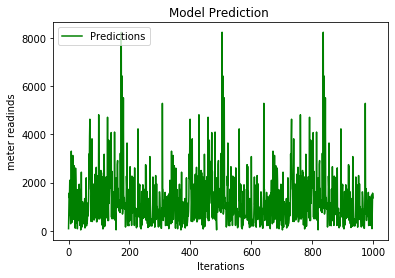

In [633]:
plt.plot(pred,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('Model Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

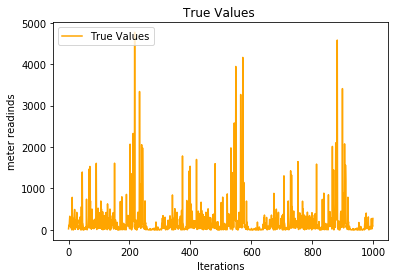

In [195]:
#plt.plot(predictions,"-g" ,label='Predictions')
plt.plot(true_values, "-r",label='True Values',color='orange')
plt.legend(loc="upper left")
plt.title('True Values ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

In [ ]:
plt.plot(true_values, "-r",label='True Values',color='orange')
plt.plot(predictions,"-g" ,label='Predictions',color='green')

plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='x-large')
plt.tight_layout()

plt.title('Model Prediction and True Values Imposed')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

# save model

In [634]:
featuresample = list(dataset.take(1))[0][0]

In [635]:
# input function
inut_receive_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(featuresample)

In [636]:
model.export_saved_model(export_dir_base='wide_model',serving_input_receiver_fn=inut_receive_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Regression input must be a single string Tensor; got {'square_feet': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=int32>, 'air_temperature': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float64>, 'dew_temperature': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=float64>, 'month_day': <tf.Tensor 'Placeholder_3:0' shape=(?, 2) dtype=int32>, 'primary_use': <tf.Tensor 'Placeholder_4:0' s

b'wide_model/1577980740'